In [ ]:
# !pip install gcpds
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.filters.git
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.utils.git
# FILEID = "121RAmnPo8lMxvEywEkT2wyFJNTaticlD" 
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O EEGFeatExtraction.py && rm -rf /tmp/cookies.txt !pip install -U git+https://github.com/UN-GCPDS/python-gcpds.filters.git 
!pip install mne

  Cloning https://github.com/UN-GCPDS/python-gcpds.filters.git to /tmp/pip-req-build-neb4emce
  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.filters.git /tmp/pip-req-build-neb4emce
  Created wheel for gcpds-filters: filename=gcpds_filters-0.1a0-py3-none-any.whl size=817588 sha256=5a58eaa30e5849f63f67defc0b238c0037a0cd40e7a601598e0992babd133b03
  Stored in directory: /tmp/pip-ephem-wheel-cache-yo6nvsqb/wheels/36/7a/78/d27d0f0c7be2222e2c76dcafd6840212fbc620d24f8a7c13f0
Successfully built gcpds-filters
  Cloning https://github.com/UN-GCPDS/python-gcpds.utils.git to /tmp/pip-req-build-r958z346
  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.utils.git /tmp/pip-req-build-r958z346
     |████████████████████████████████| 6.9 MB 5.6 MB/s 
  Created wheel for gcpds-utils: filename=gcpds_utils-0.1a3-py3-none-any.whl size=116894 sha256=2e9d4f6ba9fb4cf286e150587dec2004173f65fb49d7defb399a53df7ee3d774
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [ ]:
import mne
from mne.preprocessing import ICA
from google.colab import drive
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import pickle
from ipywidgets import interact_manual
from ipywidgets import interact
# from MIfunctions import *
# from CKA_keras import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from time import time
import os
import numpy as np
from numpy import angle, sin, cos, sqrt
from scipy.io import loadmat
# from mat73 import loadmat
import scipy as sp
from scipy.io import savemat
from scipy.signal import butter, lfilter, welch, hanning, filtfilt, hilbert
import matplotlib.pyplot as plt
from gcpds.utils import loaddb
from gcpds.utils.visualizations import plot_eeg, plot_topoplot

In [ ]:
def ICA_EEG(X, info, EOG_channels, EEG_channels):
  # X_= X[:len(EEG_channels),:]
  X_ = X.get_data()[:,:len(EEG_channels),:]
  EEG_ICA = np.zeros(X_.shape)
  signals = X #mne.io.RawArray(X, info)
  filt_signals = signals.copy()
  ica = mne.preprocessing.ICA(n_components=len(EEG_channels),random_state=97)
  ica.fit(filt_signals)
  eog_indices = []
  eog_scores = []
  for eog_ch in EOG_channels:
    eog_indices_aux, eog_scores_aux = ica.find_bads_eog(filt_signals, ch_name=eog_ch, threshold=3.0, verbose=False)
    eog_scores.append(eog_scores_aux)
    if len(eog_indices_aux)>0:
        for IC in eog_indices_aux:
          if IC not in eog_indices:
            eog_indices.append(IC)
  ica.exclude = eog_indices
  reconst_raw = signals.copy()
  ica.apply(reconst_raw)
  # ._data[0:len(EEG_channels),:]
  return reconst_raw, eog_indices, np.round(np.array(eog_scores),4), ica    


sujeto:  3


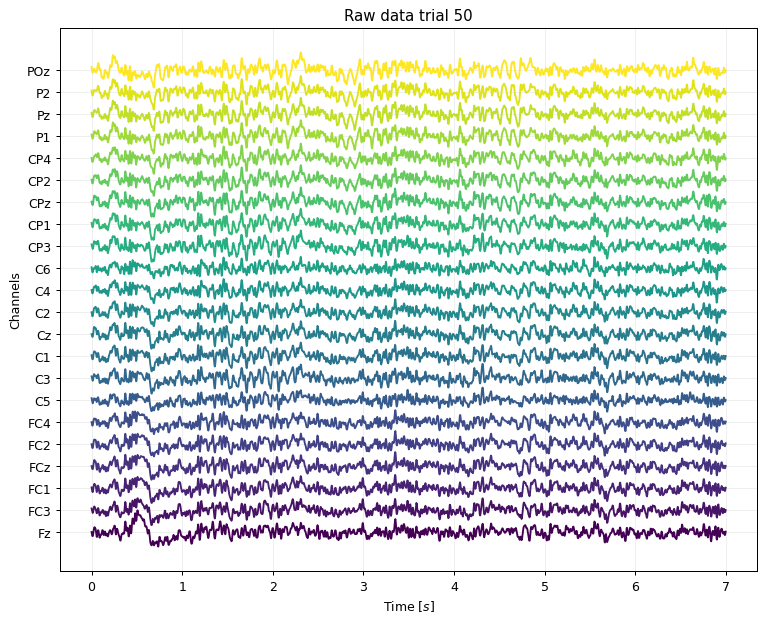

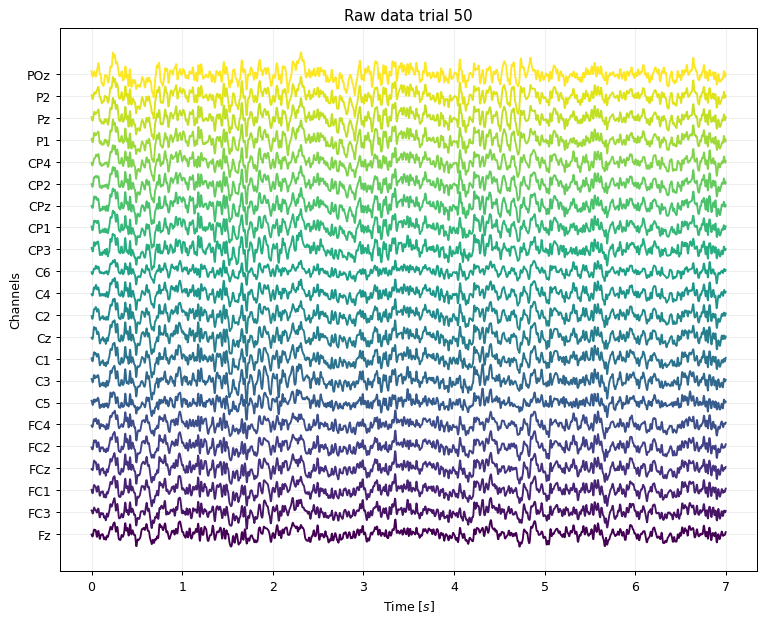

sujeto:  5


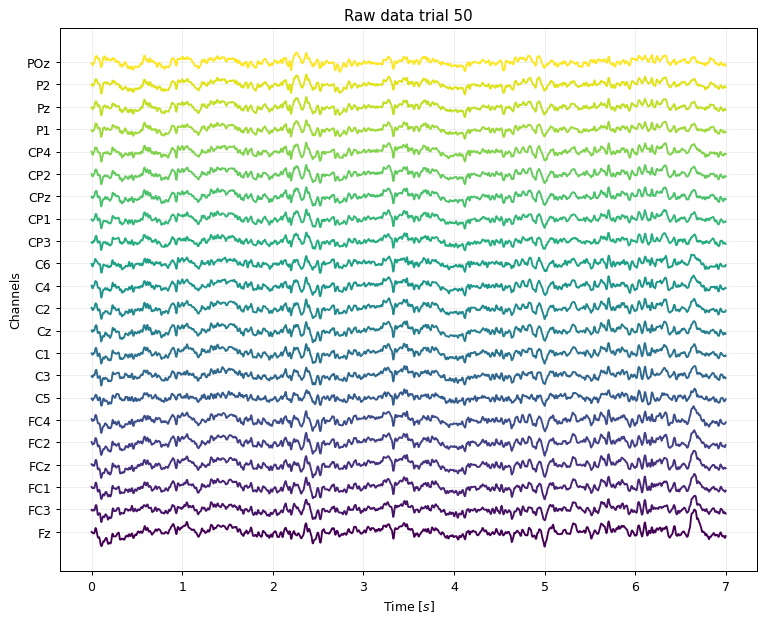

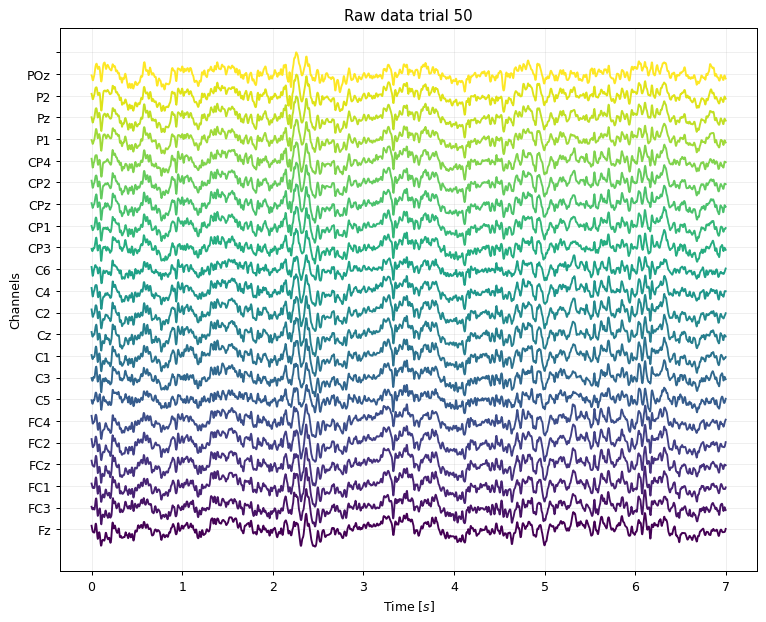

In [ ]:
## resting data
# Subjects= np.arange(1,1)
# Subjects = list(np.arange(1,22))
# channels = ['Fp1','Fp2','F7','F3','Fz','F4','F8','T3','C3','Cz','C4','T4',
            # 'T5','P3','Pz','P4','T6','O1','O2']
# n_channels    = 22
sampling_freq = 250         # Frecuencia de muestreo de la base de datos.

# load_path = '/content/drive/Shareddrives/GCPDS/databases/Auditory_processing/'
# ch_names = channels
# y = list()
# method = 'fastica'
data_ref = list()
data_ref_raw = list()
raw_ = list()
X_ica_ = list()
db = loaddb.BCI_CIV_2a()
for s in [3,5]:#Subjects:
  # S_ERP = loadmat(load_path + f"P"+str(s)+"_BCMI_frontHN_2017.mat")
  print('sujeto: ', s)
  db.load_subject(s)
  [data,clases] =db.get_data()
  channels = db.metadata['channels']
  ch_names = channels
  n_channels = len(channels)
  sampling_freq =  db.metadata['sampling_rate']
  # data = S_ERP['base']
  # data = np.transpose(data, (1,0)) # transponer en canales x tiempo
  # data = data[:n_channels,10*sampling_freq:-10*sampling_freq]
  data_target = data#[:,:n_channels,:]
  # data_target = np.zeros((1,data.shape[0],data.shape[1]))
  # data_target[0,:,:] = data

  # for ch in range(n_channels):
  #   if ch_names[ch][0] == ' ':
  #     ch_names[ch] = ch_names[ch][1:]

  # structure 
  EOG_channels = channels[-3:]
  EEG_channels = channels[:-3]
  ch_types     = ['eeg']*len(EEG_channels)+['eog']*len(EOG_channels)
  info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
  info.set_montage('standard_1005')
  raw = mne.EpochsArray(data_target, info)

  # filtro la señal.
  raw.filter(0.5,50)
  plt.figure(figsize=(10, 8), dpi=90)
  plt.title('Raw data trial 50')
  plot_eeg(raw.get_data()[50,:-3,:], EEG_channels, sampling_freq)
  plt.show()
  # Repairing artifacts with ICA
  X_ica, ind, scores, ica = ICA_EEG(raw, info, EOG_channels, EEG_channels)
  
  # 
  EEG_channels = channels[:-3]
  ch_types     = ['eeg']*len(EEG_channels)
  ch_names_ = ch_names[:-3]
  info = mne.create_info(ch_names_, ch_types=ch_types, sfreq=sampling_freq)
  info.set_montage('standard_1005')
  #
  rawt = mne.EpochsArray(raw.get_data()[:,:-3,:], info)
  raw_.append(rawt)
  #
  xica = mne.EpochsArray(X_ica.get_data()[:,:-3,:], info)
  X_ica_.append(xica)
  # X_ica_o.append(mne.EpochsArray(X_ica.get_data()[:,-3:,:], info))

  # raw_o.append(mne.EpochsArray(raw.get_data()[:,:-3,:], info))
  # ica.plot_sources(raw, show_scrollbars=False)
  # ica = ICA(n_components=19, method=method,max_iter='auto', random_state=0)
  # ica.fit(raw,)
  # ica.exclude = [11,16,18]         # indices chosen based on various plots above sujeto 2
  # ica.exclude = [19] #[5,6,13,16]  # indices chosen based on various plots above sujeto 7
  # # ica.plot_components()
  # # ica.plot_sources(raw, show_scrollbars=False,)
  # ica.apply(raw)
  # ica.plot_sources(mne.io.RawArray(Xraw[50], info))
  raw.filter(0.5,50)
  plt.figure(figsize=(10, 8), dpi=90)
  plt.title('Raw data trial 50')
  plot_eeg(X_ica.get_data()[50,:-3,:], EEG_channels, sampling_freq)
  plt.show()

  # CAR common average reference
  # rereferenced_raw, ref_data = mne.set_eeg_reference(X_ica, ref_channels='average',projection=True,verbose=0)
  # data_ref.append(rereferenced_raw.get_data())
  data_ref.append(xica.get_data())

  # rereferenced_raw, ref_data = mne.set_eeg_reference(raw, ref_channels='average',projection=True,verbose=0)
  # data_ref_raw.append(rereferenced_raw.get_data())
  data_ref_raw.append(raw.get_data())

  # filter small laplacian 
  # lab = small_laplacian(data_target,ch_names,'standard_1005')
  # data_ref.append(lab)

In [ ]:
X_ica.get_data().shape

(262, 25, 1750)

# Entropia

1. prueba con tau: 20, ventana: 3seg,  traslape: 50.
2. prueba con tau: 30, ventana: 3seg,  traslape: 80.

In [ ]:
import time
import vq_function as vq

def fun_entropy(data):
  tau = 5
  entropy_ch = list()
  for ch in range(data.shape[0]):
    signal = np.squeeze(data[ch,:]).reshape(1,-1)
    r = 0.2*np.std(signal)
    E = vq.bayes_entropy2(signal,r,tau)
    entropy_ch.append(E)
  return np.asarray(entropy_ch)

In [ ]:
window  = 1*sampling_freq # 1,2 segundos
step    = window*0.1 # 90%
windows = list(np.arange(0,data_ref_raw[0].shape[2]-window,step))
len(windows)

60

In [ ]:
import multiprocessing
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

# tau = 3 # 2,3,4
window  = 1*sampling_freq # 1,2 segundos
step    = window*0.1 # 90%
windows = list(np.arange(0,data_ref_raw[0].shape[2]-window,step))
# datos = np.squeeze(ica.get_sources(raw,).get_data(['misc']*19))

entropy_raw = list()
for sub in [0,1]:#Subjects:
  entropy_tr  = list()
  for tr in range(data_ref_raw[sub].shape[0]):
    # start_time = time.time()
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(data_ref_raw[sub][tr,:,int(windows[time_]):int(windows[time_]+window)])
      # signal = np.squeeze(datos[:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    entropy_t = pool.map(fun_entropy, data)
    entropy_tr.append(np.asarray(entropy_t))
  entropy_sub = (np.asarray(entropy_tr))
  entropy_raw.append(np.asarray(entropy_sub))

In [ ]:
entropy_raw[0].shape

(270, 60, 25)

In [ ]:
import multiprocessing
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

# tau = 3 # 2,3,4
window  = 1*sampling_freq # 1,2 segundos
step    = window*0.1 # 90%
windows = list(np.arange(0,data_ref[0].shape[2]-window,step))
# datos = np.squeeze(ica.get_sources(raw,).get_data(['misc']*19))

entropy_8 = list()
for sub in [0,1]:#Subjects:
  entropy_tr  = list()
  for tr in range(data_ref[sub].shape[0]):
    # start_time = time.time()
    data = list()
    for time_ in range(len(windows)):
      signal = np.squeeze(data_ref[sub][tr,:,int(windows[time_]):int(windows[time_]+window)])
      # signal = np.squeeze(datos[:,int(windows[time_]):int(windows[time_]+window)])
      data.append(signal)
    entropy_t = pool.map(fun_entropy, data)
    entropy_tr.append(np.asarray(entropy_t))
  entropy_sub = (np.asarray(entropy_tr))
  entropy_8.append(np.asarray(entropy_sub))

In [ ]:
entropy_8[0].shape

(270, 60, 22)

In [ ]:
from scipy.stats import pearsonr
# chans = [0,19]
corr_sub = []
for s in range(2):
  corr_tr = []
  for tr in range(data_ref[sub].shape[0]):
    corr_ch = []
    for ch in range(data_ref[sub].shape[1]):
      prod_r = abs(pearsonr(np.squeeze(raw_[s].get_data()[tr,ch,:]),(np.squeeze(X_ica_[s].get_data()[tr,ch,:])))[0])
      prod = abs(pearsonr(np.squeeze(entropy_raw[s][tr,:,ch]),(np.squeeze(entropy_8[s][tr,:,ch])))[0])
      corr_ch.append([prod_r,prod])
    corr_tr.append(np.asarray(corr_ch))
  corr_sub.append(np.asarray(corr_tr))

In [ ]:
corr_sub[0][:,0,1]

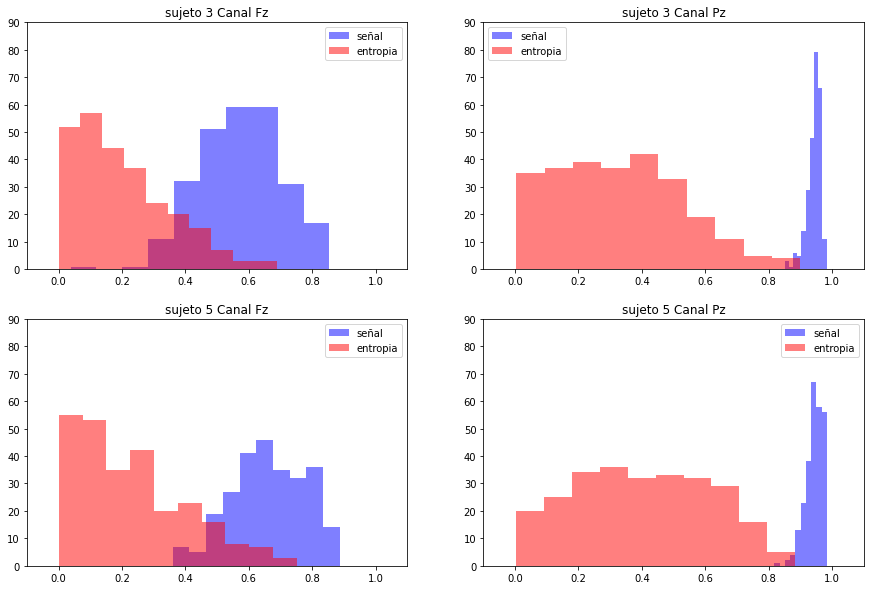

In [ ]:
import matplotlib.mlab as mlab
# num_bins = 20
# the histogram of the data
plt.figure(figsize=(15,10))
pos = 1
subs = [3,5]
chans= [0,19]
for s in range(2):
  for ch in range(2):
    plt.subplot(2,2,pos)
    n, bins, patches = plt.hist(corr_sub[s][:,ch,0], facecolor='blue', alpha=0.5,label='corr señal')
    # plt.ylim((0,90))
    # plt.xlim((-0.1,1.1))
    n, bins, patches = plt.hist(corr_sub[s][:,ch,1], facecolor='red', alpha=0.5,label='entropia')
    plt.ylim((0,90))
    plt.xlim((-0.1,1.1))
    plt.title(f'sujeto '+str(subs[s])+' Canal '+str(ch_names[chans[ch]]))
    plt.legend()
    pos +=1
# add a 'best fit' line
# plt.xlabel('Smarts')
# plt.ylabel('Probability')
# plt.title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

# Tweak spacing to prevent clipping of ylabel
# plt.subplots_adjust(left=0.15)
plt.show()

In [ ]:
corr_sub[s].shape

(262, 19, 2)

In [ ]:
print(np.argsort(ydata[0],))

[ 0 12  5  1  4  2  3 11  6 10  7  8  9 17 16 14 13 15 19 20 18 21]


In [ ]:
import matplotlib
# Visualize the result
ydata = []
ydata_= []
for s in range(2):
  ydata.append(np.mean(corr_sub[s][:,:,0],axis=0))
  ydata_.append(np.std(corr_sub[s][:,:,0],axis=0))
xdata = list(np.arange(1,23))

s = 0
xfit = xdata
yfit = ydata[s]
yfit_ord=np.sort(yfit)[::-1]
ranked = np.argsort(yfit)[::-1]
dyfit= ydata_[s]
dyfit_ord = dyfit[ranked]
plt.figure(figsize=(10,5))
# plt.plot(xdata, ydata[0], 'ob')
plt.subplot(2,1,1)
plt.plot(xfit, yfit, '-', color='b')
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit,
                 color='b', alpha=0.2)
plt.xticks(xdata, ch_names_, rotation ='vertical')

pruh = np.array([73.22903841, 70.36685154, 71.93807267, 72.27398816, 72.0169495 , 70.79382266, 65.78417807, 69.35931554, 71.11573205, 71.57963773, 71.32510556, 69.98754197, 67.02127266, 68.74533049, 70.26278755, 70.71856759, 70.91967875, 69.44096675, 68.54816864, 69.87676106, 69.02758106, 67.14803908])/100
s = 1
xfit = xdata
yfit = ydata[s]
yfit_ord=np.sort(yfit)[::-1]
ranked = np.argsort(yfit)[::-1]
dyfit= ydata_[s]
dyfit_ord = dyfit[ranked]
# plt.plot(xdata, ydata[0], 'ob')
plt.plot(xfit, pruh, '-', color='r') # yfit
# plt.fill_between(xfit, yfit - dyfit, yfit + dyfit,
                #  color='r', alpha=0.2)
plt.xticks(xdata, ch_names_, rotation ='vertical')
plt.xlim(0.5, 22.5)
plt.margins(0.2)


plt.subplot(2,1,2)
s = 0
xfit = xdata
yfit = ydata[s]
yfit_ord=np.sort(yfit)[::-1]
ranked = np.argsort(yfit)[::-1]
dyfit= ydata_[s]
dyfit_ord = dyfit[ranked]
plt.plot(xfit, yfit_ord, '-', color='b')
plt.fill_between(xfit, yfit_ord - dyfit_ord, yfit_ord + dyfit_ord,
                 color='b', alpha=0.2)
s = 1
xfit = xdata
yfit = ydata[s]
yfit_ord=np.sort(yfit)[::-1]
dyfit= ydata_[s]
dyfit_ord = dyfit[ranked]
plt.plot(xfit, yfit_ord, '-', color='r')
plt.fill_between(xfit, yfit_ord - dyfit_ord, yfit_ord + dyfit_ord,
                 color='r', alpha=0.2)


plt.xlim(0.5, 22.5)
plt.margins(0.2)
ch_names_2 = np.asarray(ch_names_)[ranked]
plt.xticks(xdata, ch_names_2, rotation ='vertical')
# plt.xticks(xdata, ch_names[:-3], rotation ='vertical')

plt.show()
mne.viz.plot_topomap(yfit,info,sensors=True,cmap='viridis',vmin=0,vmax=1)
plt.show()

NameError: ignored

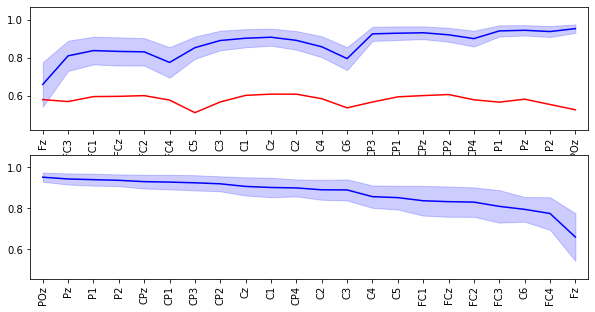

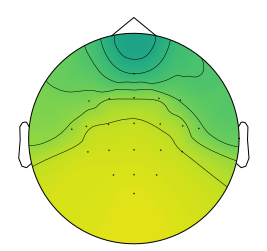

In [ ]:
import matplotlib
# Visualize the result
ydata = []
ydata_= []
for s in range(2):
  ydata.append(np.mean(corr_sub[s][:,:,0],axis=0))
  ydata_.append(np.std(corr_sub[s][:,:,0],axis=0))
xdata = list(np.arange(1,23))

s = 1
xfit = xdata
yfit = ydata[s]
yfit_ord=np.sort(yfit)[::-1]
ranked = np.argsort(yfit)[::-1]
dyfit= ydata_[s]
dyfit_ord = dyfit[ranked]
plt.figure(figsize=(10,5))
# plt.plot(xdata, ydata[0], 'ob')
plt.subplot(2,1,1)
plt.plot(xfit, yfit, '-', color='b')
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit,
                 color='b', alpha=0.2)
plt.xticks(xdata, ch_names_, rotation ='vertical')

pruh = np.array([58.05454432, 57.00774976, 59.61865232, 59.74830306, 60.13184161, 57.79064793, 51.20546213, 56.81848467, 60.26814137, 60.90584047, 60.88205415, 58.51667947, 53.71704311, 56.77888271, 59.48532615, 60.14644505, 60.70722964, 57.94597986, 56.70666397, 58.26940798, 55.47696022, 52.72390053])/100
# s = 1
# xfit = xdata
# yfit = ydata[s]
# yfit_ord=np.sort(yfit)[::-1]
# ranked = np.argsort(yfit)[::-1]
# dyfit= ydata_[s]
# dyfit_ord = dyfit[ranked]
# # plt.plot(xdata, ydata[0], 'ob')
plt.plot(xfit, pruh, '-', color='r') # yfit
# plt.fill_between(xfit, yfit - dyfit, yfit + dyfit,
#                  color='r', alpha=0.2)
# plt.xticks(xdata, ch_names_, rotation ='vertical')
plt.xlim(0.5, 22.5)
plt.margins(0.2)


plt.subplot(2,1,2)
s = 1
xfit = xdata
yfit = ydata[s]
yfit_ord=np.sort(yfit)[::-1]
ranked = np.argsort(yfit)[::-1]
dyfit= ydata_[s]
dyfit_ord = dyfit[ranked]
plt.plot(xfit, yfit_ord, '-', color='b')
plt.fill_between(xfit, yfit_ord - dyfit_ord, yfit_ord + dyfit_ord,
                 color='b', alpha=0.2)
# s = 1
# xfit = xdata
# yfit = ydata[s]
# yfit_ord=np.sort(yfit)[::-1]
# dyfit= ydata_[s]
# dyfit_ord = dyfit[ranked]
# plt.plot(xfit, yfit_ord, '-', color='r')
# plt.fill_between(xfit, yfit_ord - dyfit_ord, yfit_ord + dyfit_ord,
#                  color='r', alpha=0.2)


plt.xlim(0.5, 22.5)
plt.margins(0.2)
ch_names_2 = np.asarray(ch_names_)[ranked]
plt.xticks(xdata, ch_names_2, rotation ='vertical')
# plt.xticks(xdata, ch_names[:-3], rotation ='vertical')

plt.show()
mne.viz.plot_topomap(yfit,info,sensors=True,cmap='viridis',vmin=0,vmax=1)
plt.show()

In [ ]:
import matplotlib.mlab as mlab
# num_bins = 20
# the histogram of the data
plt.figure(figsize=(15,10))
pos = 1
subs = [3,5]
chans= [0,19]
for s in range(2):
  for ch in range(2):
    plt.subplot(2,2,pos)
    n, bins, patches = plt.hist(corr_sub[s][:,ch,0], facecolor='blue', alpha=0.5,label='corr señal')
    # plt.ylim((0,90))
    # plt.xlim((-0.1,1.1))
    n, bins, patches = plt.hist(corr_sub[s][:,ch,1], facecolor='red', alpha=0.5,label='corr entropia')
    plt.ylim((0,90))
    plt.xlim((-0.1,1.1))
    plt.title(f'sujeto '+str(subs[s])+' Canal '+str(ch_names[chans[ch]]))
    plt.legend()
    pos +=1
# add a 'best fit' line
# plt.xlabel('Smarts')
# plt.ylabel('Probability')
# plt.title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

# Tweak spacing to prevent clipping of ylabel
# plt.subplots_adjust(left=0.15)
plt.show()

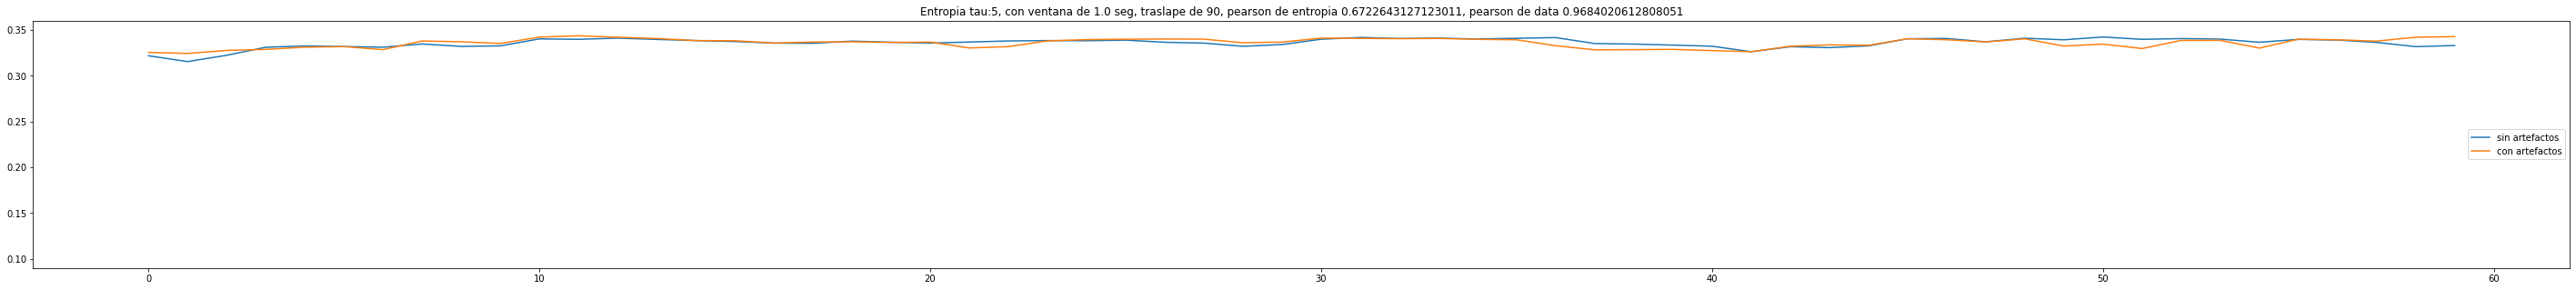

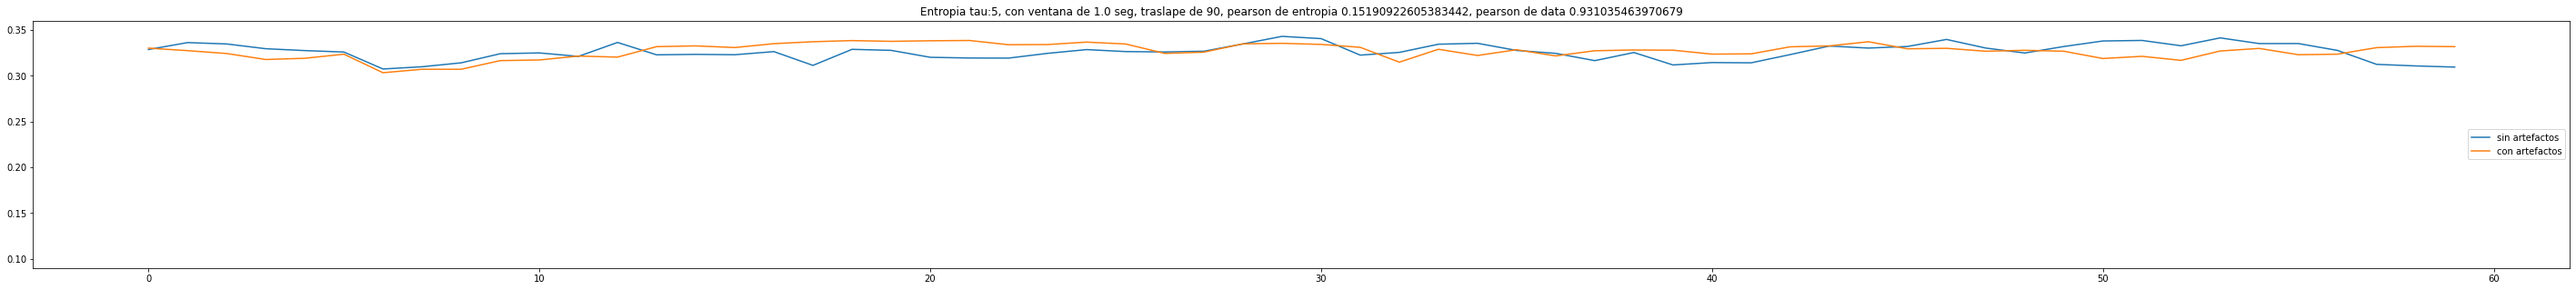

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

for s in range(2):
  prod_r = abs(pearsonr(np.squeeze(raw_[s].get_data()[50,19,:]),(np.squeeze(X_ica_[s].get_data()[50,19,:])))[0])
  prod = abs(pearsonr(np.squeeze(entropy_8[s][:,0]),(np.squeeze(entropy_raw[s][:,0])))[0])
  plt.figure(figsize=(50,5))
  for i in range(entropy_8[s].shape[1]):
    plt.plot(np.squeeze(entropy_8[s][:,i]), label='sin artefactos')
    plt.plot(np.squeeze(entropy_raw[s][:,i]), label='con artefactos')

  plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
  plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, pearson de entropia {pro}, pearson de data {porr}'.format(tau_=5,ven=window/sampling_freq,tra=90,pro=prod,porr=prod_r))
  plt.ylim(0.09,0.36)
plt.show()

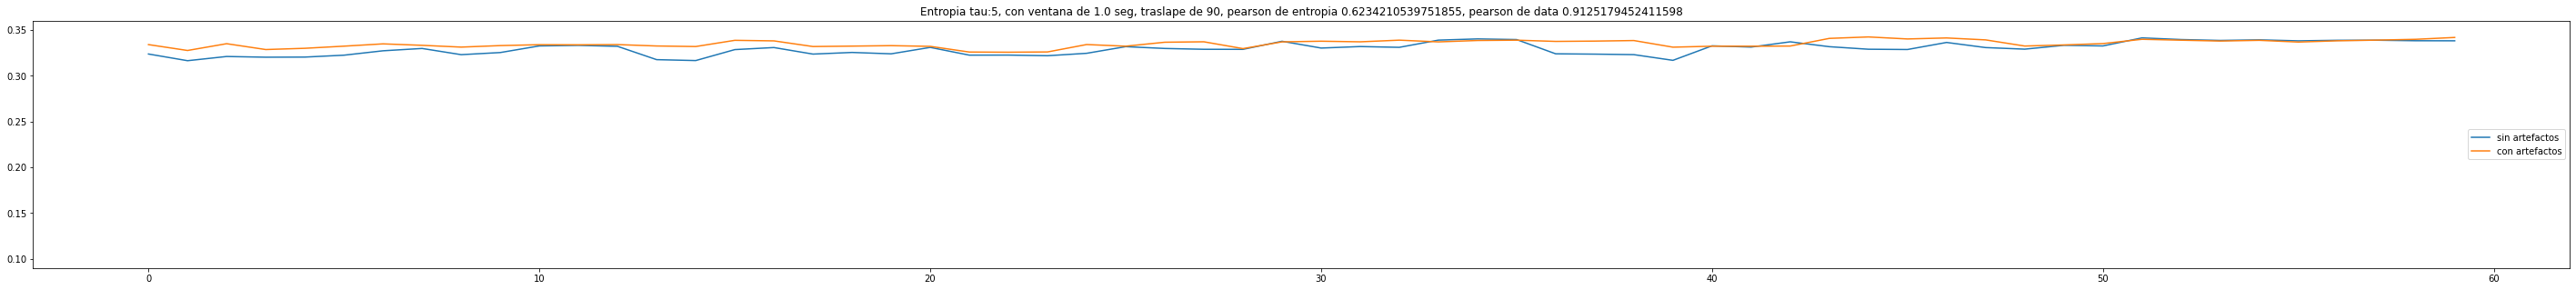

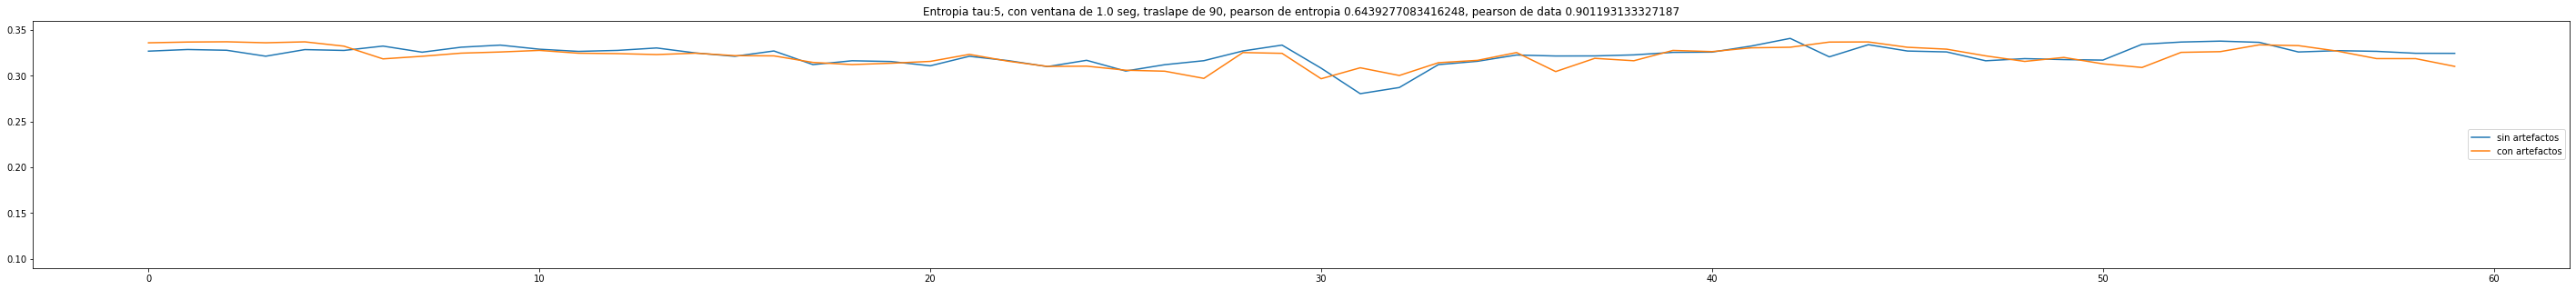

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
for s in range(2):
  prod_r = abs(pearsonr(np.squeeze(raw_[s].get_data()[50,9,:]),(np.squeeze(X_ica_[s].get_data()[50,9,:])))[0])
  prod = abs(pearsonr(np.squeeze(entropy_8[s][:,0]),(np.squeeze(entropy_raw[s][:,0])))[0])
  plt.figure(figsize=(50,5))
  for i in range(entropy_8[s].shape[1]):
    plt.plot(np.squeeze(entropy_8[s][:,i]), label='sin artefactos')
    plt.plot(np.squeeze(entropy_raw[s][:,i]), label='con artefactos')

  plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
  plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, pearson de entropia {pro}, pearson de data {porr}'.format(tau_=5,ven=window/sampling_freq,tra=90,pro=prod,porr=prod_r))
  plt.ylim(0.09,0.36)
plt.show()

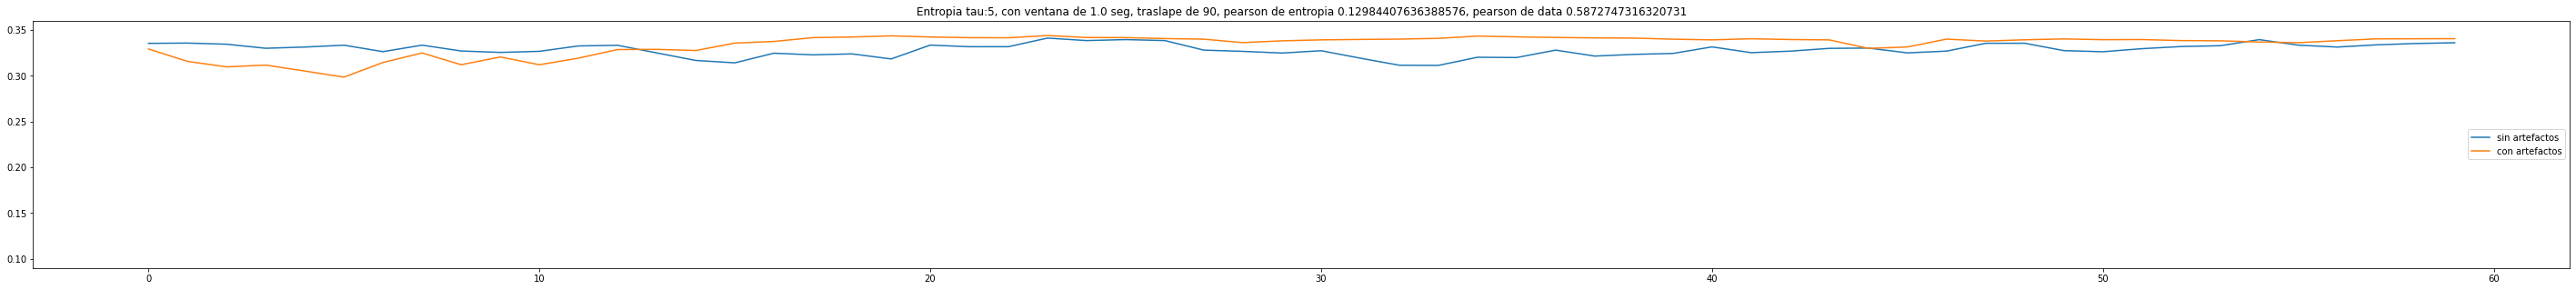

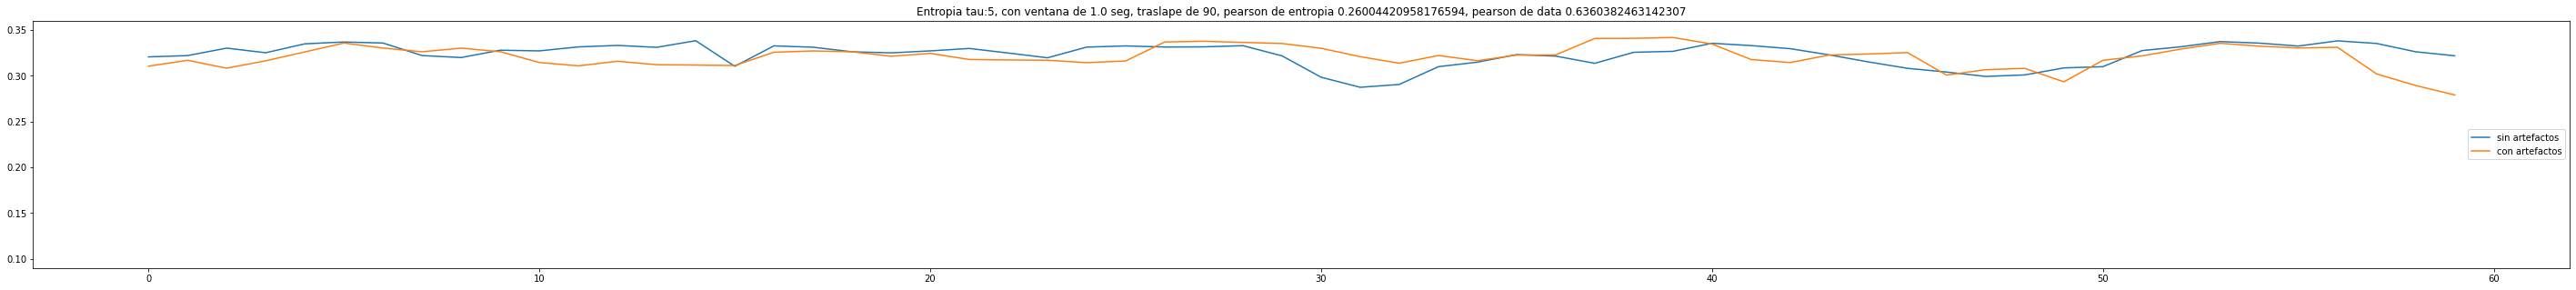

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
for s in range(2):
  prod_r = abs(pearsonr(np.squeeze(raw_[s].get_data()[50,0,:]),(np.squeeze(X_ica_[s].get_data()[50,0,:])))[0])
  prod = abs(pearsonr(np.squeeze(entropy_8[s][:,0]),(np.squeeze(entropy_raw[s][:,0])))[0])
  plt.figure(figsize=(50,5))
  for i in range(entropy_8[s].shape[1]):
    plt.plot(np.squeeze(entropy_8[s][:,i]), label='sin artefactos')
    plt.plot(np.squeeze(entropy_raw[s][:,i]), label='con artefactos')

  plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
  plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, pearson de entropia {pro}, pearson de data {porr}'.format(tau_=5,ven=window/sampling_freq,tra=90,pro=prod,porr=prod_r))
  plt.ylim(0.09,0.36)
plt.show()

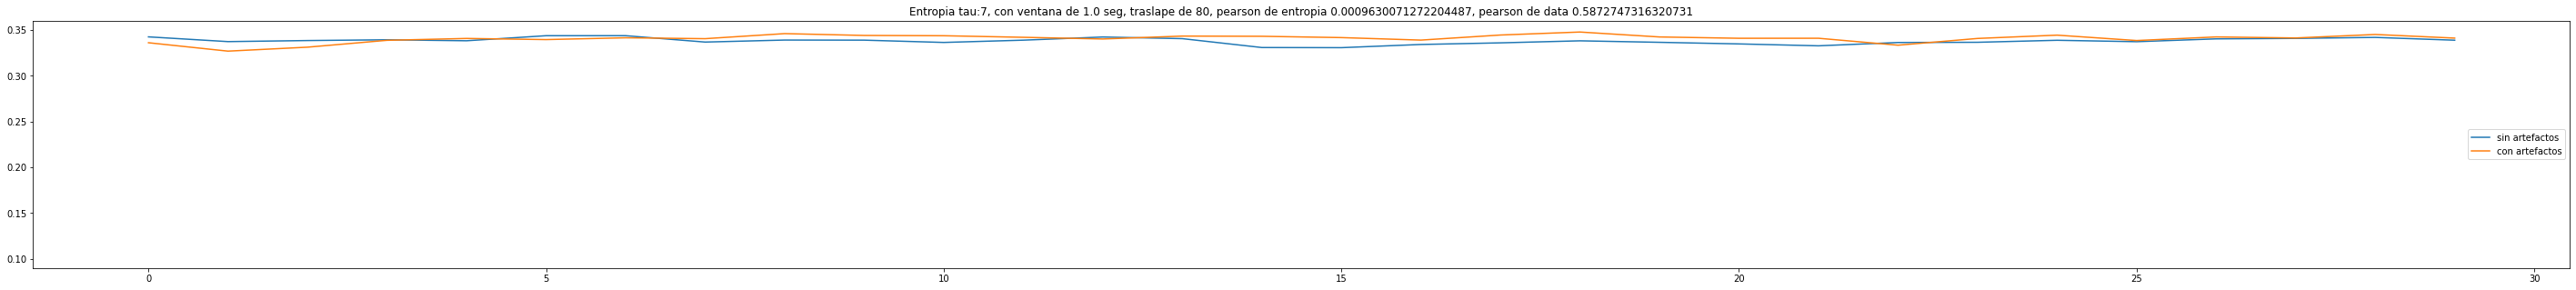

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
prod_r = abs(pearsonr(np.squeeze(raw.get_data()[50,0,:]),(np.squeeze(X_ica.get_data()[50,0,:])))[0])
prod = abs(pearsonr(np.squeeze(entropy_8[0][:,0]),(np.squeeze(entropy_raw[0][:,0])))[0])
plt.figure(figsize=(50,5))
for i in range(entropy_8[0].shape[1]):
  plt.plot(np.squeeze(entropy_8[0][:,i]), label='sin artefactos')
  plt.plot(np.squeeze(entropy_raw[0][:,i]), label='con artefactos')

plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, pearson de entropia {pro}, pearson de data {porr}'.format(tau_=7,ven=window/sampling_freq,tra=80,pro=prod,porr=prod_r))
plt.ylim(0.09,0.36)
plt.show()

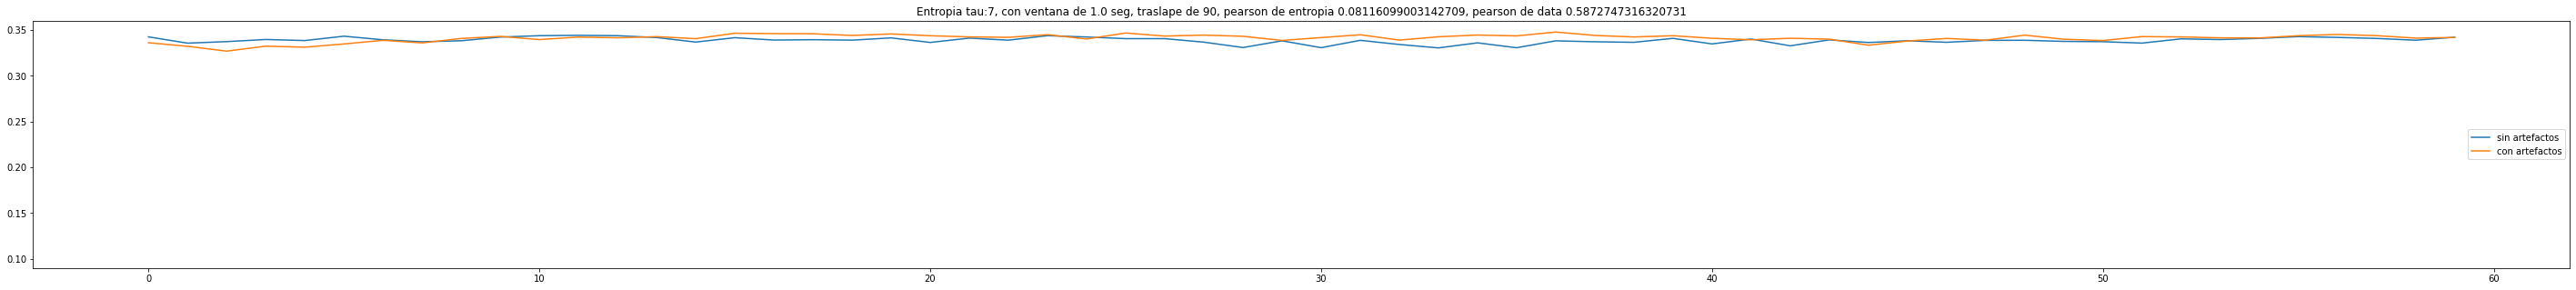

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
prod_r = abs(pearsonr(np.squeeze(raw.get_data()[50,0,:]),(np.squeeze(X_ica.get_data()[50,0,:])))[0])
prod = abs(pearsonr(np.squeeze(entropy_8[0][:,0]),(np.squeeze(entropy_raw[0][:,0])))[0])
plt.figure(figsize=(50,5))
for i in range(entropy_8[0].shape[1]):
  plt.plot(np.squeeze(entropy_8[0][:,i]), label='sin artefactos')
  plt.plot(np.squeeze(entropy_raw[0][:,i]), label='con artefactos')

plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, pearson de entropia {pro}, pearson de data {porr}'.format(tau_=7,ven=window/sampling_freq,tra=90,pro=prod,porr=prod_r))
plt.ylim(0.09,0.36)
plt.show()

In [ ]:
prod_r

0.5872747316320731

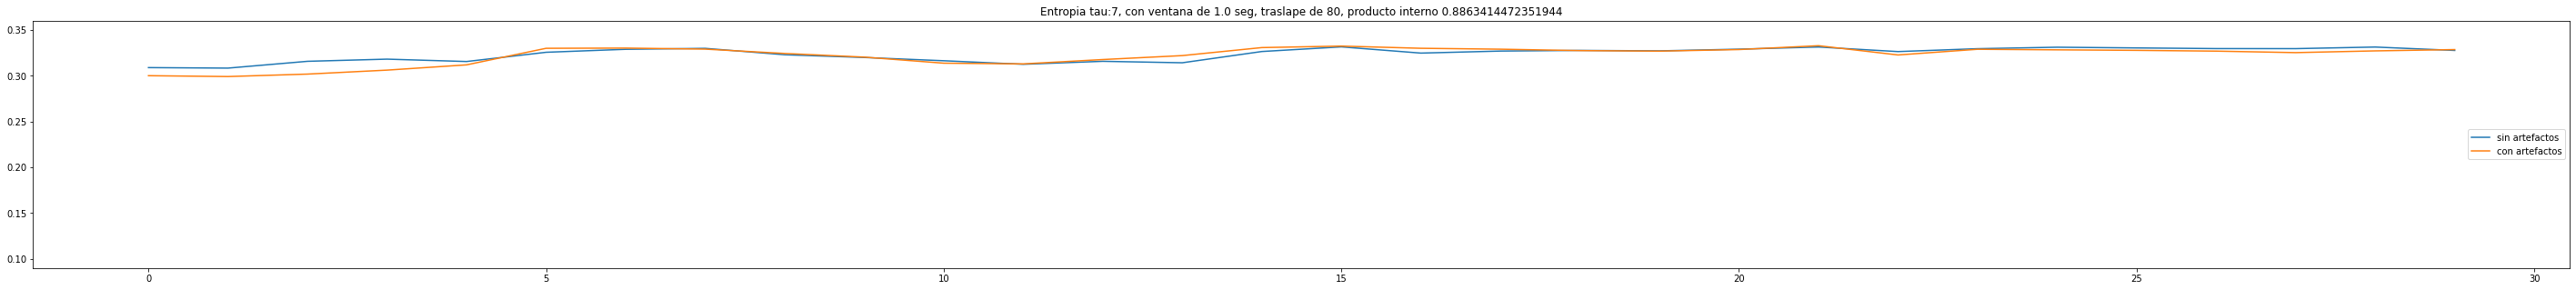

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
prod = abs(pearsonr(np.squeeze(entropy_8[0][:,i]),(np.squeeze(entropy_raw[0][:,i])))[0])
plt.figure(figsize=(50,5))
for i in range(entropy_8[0].shape[1]):
  plt.plot(np.squeeze(entropy_8[0][:,i]), label='sin artefactos')
  plt.plot(np.squeeze(entropy_raw[0][:,i]), label='con artefactos')

plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, producto interno {pro}'.format(tau_=7,ven=window/sampling_freq,tra=80,pro=prod))
plt.ylim(0.09,0.36)
plt.show()

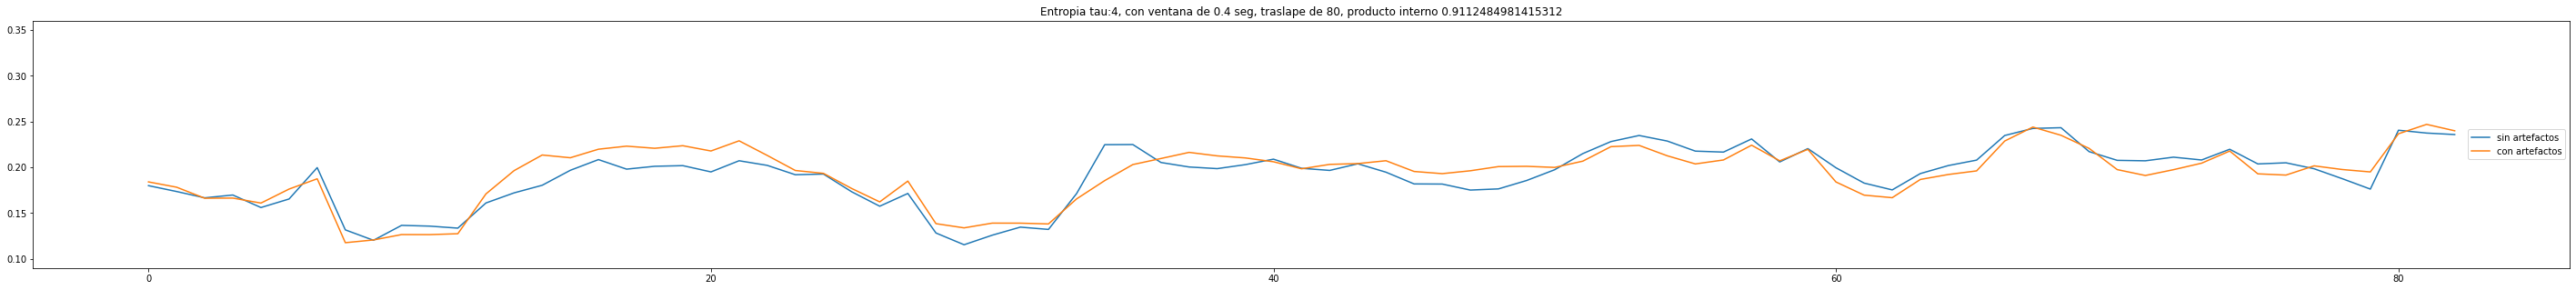

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
prod = abs(pearsonr(np.squeeze(entropy_8[0][:,i]),(np.squeeze(entropy_raw[0][:,i])))[0])
plt.figure(figsize=(50,5))
for i in range(entropy_8[0].shape[1]):
  plt.plot(np.squeeze(entropy_8[0][:,i]), label='sin artefactos')
  plt.plot(np.squeeze(entropy_raw[0][:,i]), label='con artefactos')

plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, producto interno {pro}'.format(tau_=4,ven=window/sampling_freq,tra=80,pro=prod))
plt.ylim(0.09,0.36)
plt.show()

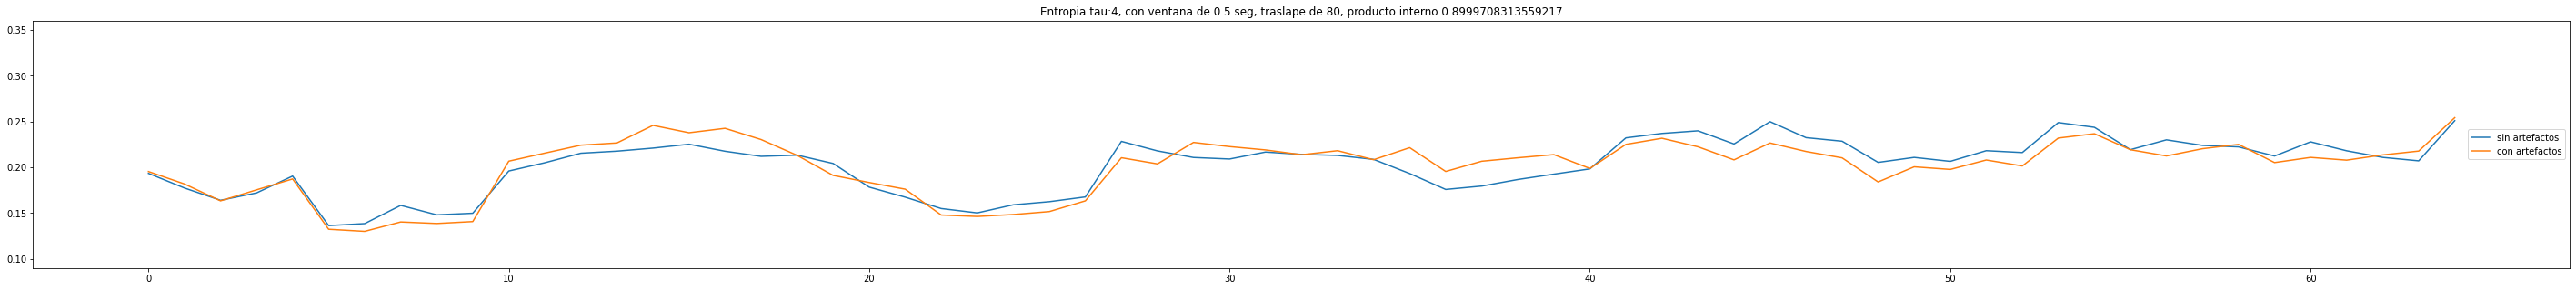

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
prod = abs(pearsonr(np.squeeze(entropy_8[0][:,i]),(np.squeeze(entropy_raw[0][:,i])))[0])
plt.figure(figsize=(50,5))
for i in range(entropy_8[0].shape[1]):
  plt.plot(np.squeeze(entropy_8[0][:,i]), label='sin artefactos')
  plt.plot(np.squeeze(entropy_raw[0][:,i]), label='con artefactos')

plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, producto interno {pro}'.format(tau_=4,ven=window/sampling_freq,tra=80,pro=prod))
plt.ylim(0.09,0.36)
plt.show()

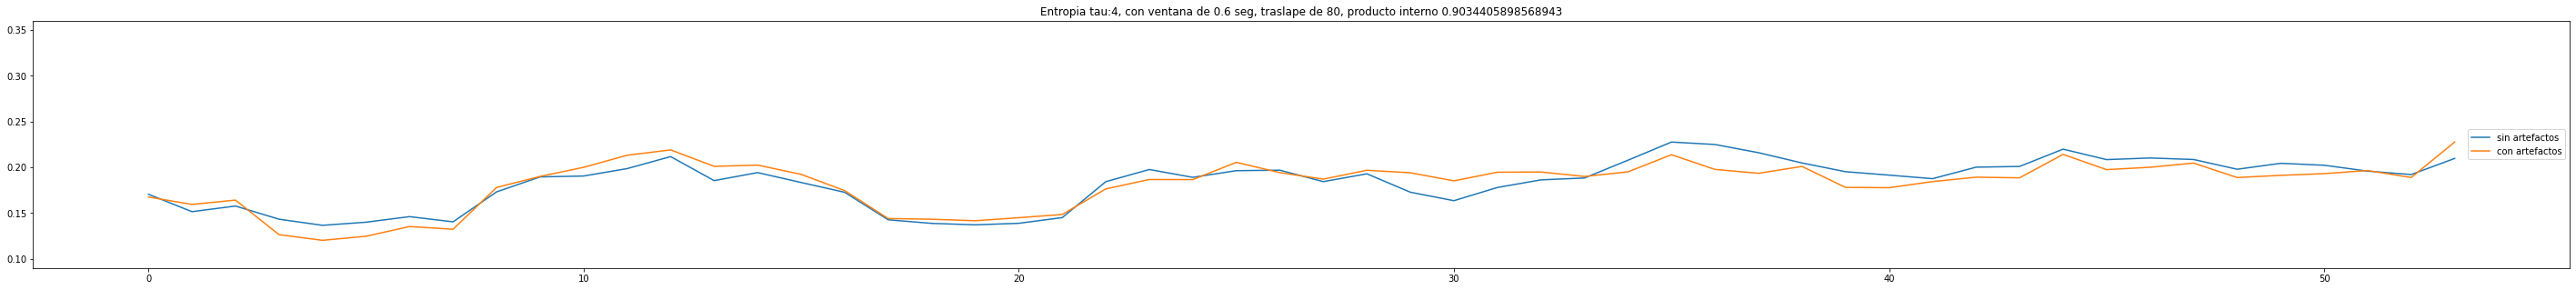

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
prod = abs(pearsonr(np.squeeze(entropy_8[0][:,i]),(np.squeeze(entropy_raw[0][:,i])))[0])
plt.figure(figsize=(50,5))
for i in range(entropy_8[0].shape[1]):
  plt.plot(np.squeeze(entropy_8[0][:,i]), label='sin artefactos')
  plt.plot(np.squeeze(entropy_raw[0][:,i]), label='con artefactos')

plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, producto interno {pro}'.format(tau_=4,ven=window/sampling_freq,tra=80,pro=prod))
plt.ylim(0.09,0.36)
plt.show()

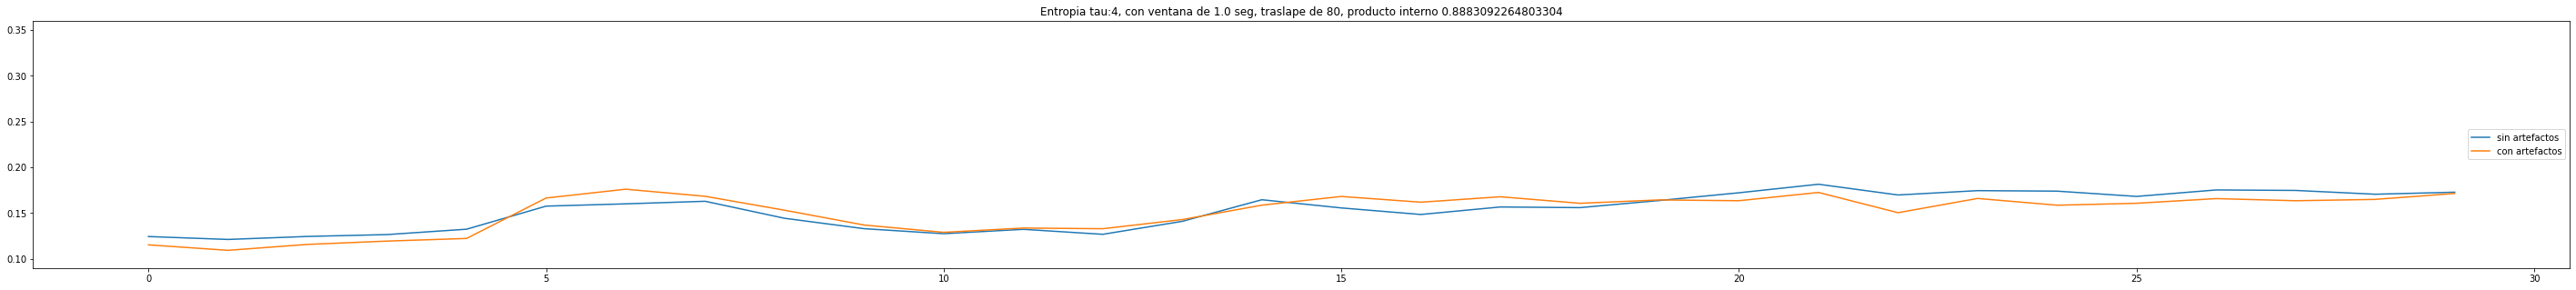

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
prod = abs(pearsonr(np.squeeze(entropy_8[0][:,i]),(np.squeeze(entropy_raw[0][:,i])))[0])
plt.figure(figsize=(50,5))
for i in range(entropy_8[0].shape[1]):
  plt.plot(np.squeeze(entropy_8[0][:,i]), label='sin artefactos')
  plt.plot(np.squeeze(entropy_raw[0][:,i]), label='con artefactos')

plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, producto interno {pro}'.format(tau_=4,ven=window/sampling_freq,tra=80,pro=prod))
plt.ylim(0.09,0.36)
plt.show()

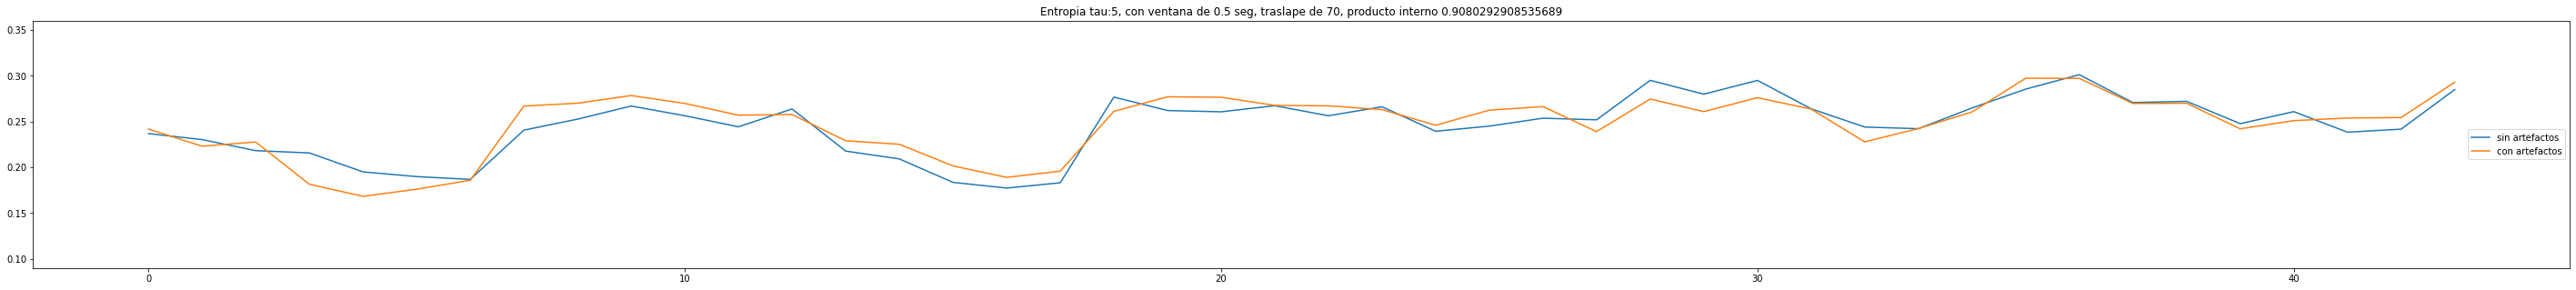

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
prod = abs(pearsonr(np.squeeze(entropy_8[0][:,i]),(np.squeeze(entropy_raw[0][:,i])))[0])
plt.figure(figsize=(50,5))
for i in range(entropy_8[0].shape[1]):
  plt.plot(np.squeeze(entropy_8[0][:,i]), label='sin artefactos')
  plt.plot(np.squeeze(entropy_raw[0][:,i]), label='con artefactos')

plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, producto interno {pro}'.format(tau_=5,ven=window/sampling_freq,tra=70,pro=prod))
plt.ylim(0.09,0.36)
plt.show()

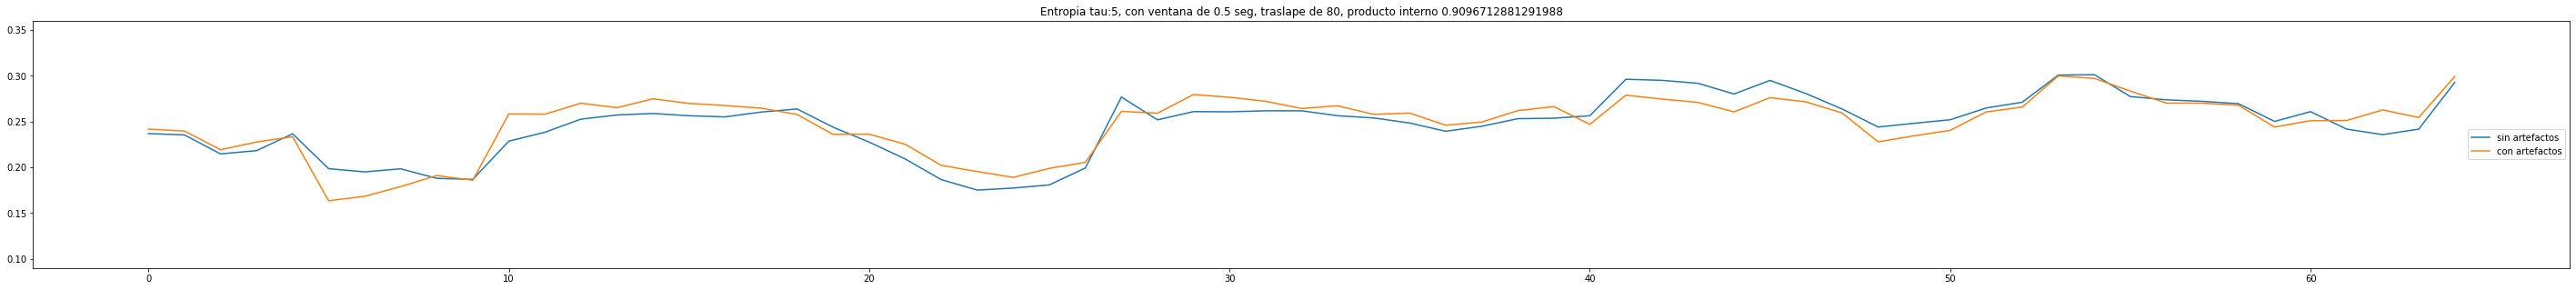

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
prod = abs(pearsonr(np.squeeze(entropy_8[0][:,i]),(np.squeeze(entropy_raw[0][:,i])))[0])
plt.figure(figsize=(50,5))
for i in range(entropy_8[0].shape[1]):
  plt.plot(np.squeeze(entropy_8[0][:,i]), label='sin artefactos')
  plt.plot(np.squeeze(entropy_raw[0][:,i]), label='con artefactos')

plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, producto interno {pro}'.format(tau_=5,ven=window/sampling_freq,tra=80,pro=prod))
plt.ylim(0.09,0.36)
plt.show()

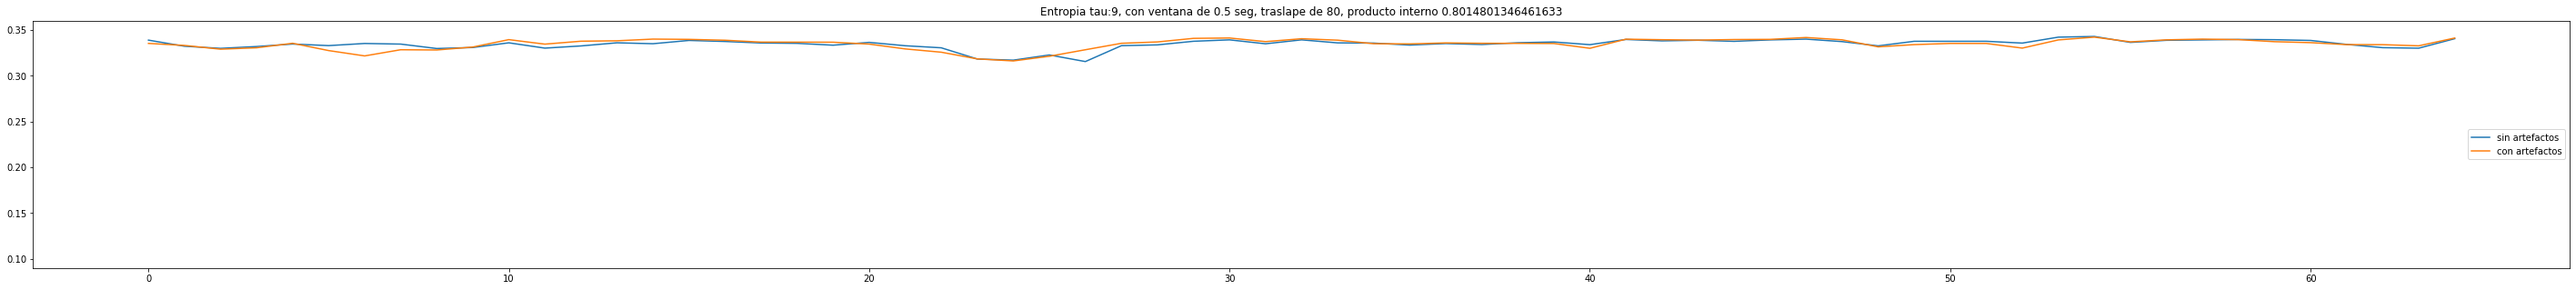

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
prod = abs(pearsonr(np.squeeze(entropy_8[0][:,i]),(np.squeeze(entropy_raw[0][:,i])))[0])
plt.figure(figsize=(50,5))
for i in range(entropy_8[0].shape[1]):
  plt.plot(np.squeeze(entropy_8[0][:,i]), label='sin artefactos')
  plt.plot(np.squeeze(entropy_raw[0][:,i]), label='con artefactos')

plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, producto interno {pro}'.format(tau_=9,ven=window/sampling_freq,tra=80,pro=prod))
plt.ylim(0.09,0.36)
plt.show()

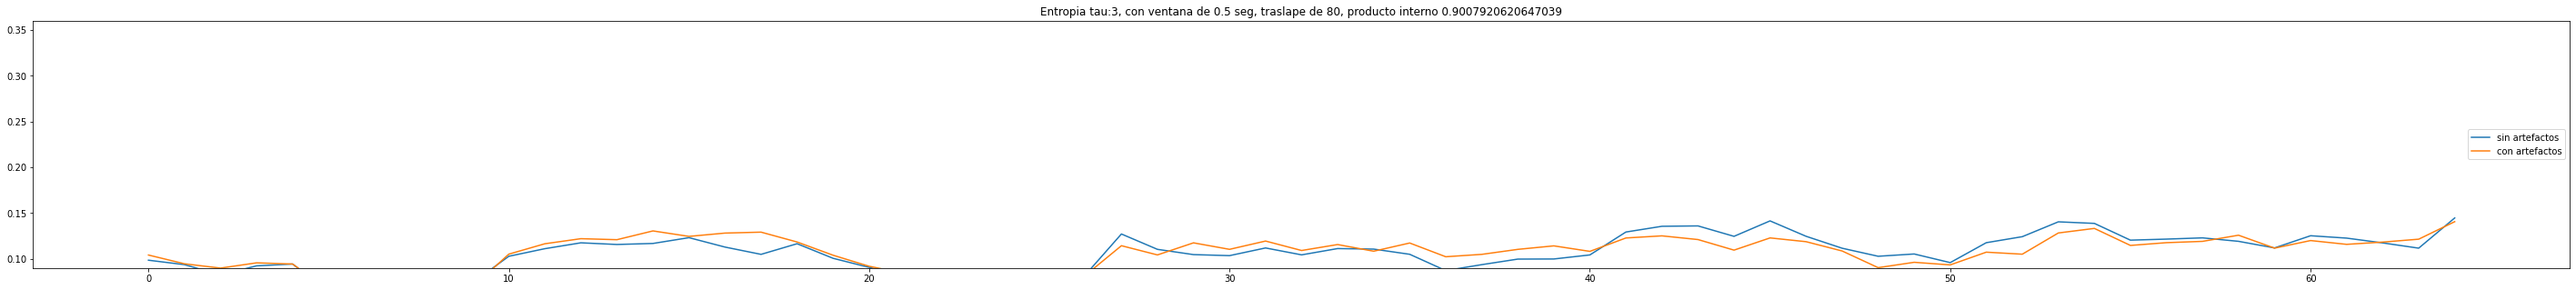

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
prod = abs(pearsonr(np.squeeze(entropy_8[0][:,i]),(np.squeeze(entropy_raw[0][:,i])))[0])
plt.figure(figsize=(50,5))
for i in range(entropy_8[0].shape[1]):
  plt.plot(np.squeeze(entropy_8[0][:,i]), label='sin artefactos')
  plt.plot(np.squeeze(entropy_raw[0][:,i]), label='con artefactos')

plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
plt.title('Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}, producto interno {pro}'.format(tau_=3,ven=window/sampling_freq,tra=80,pro=prod))
plt.ylim(0.09,0.36)
plt.show()

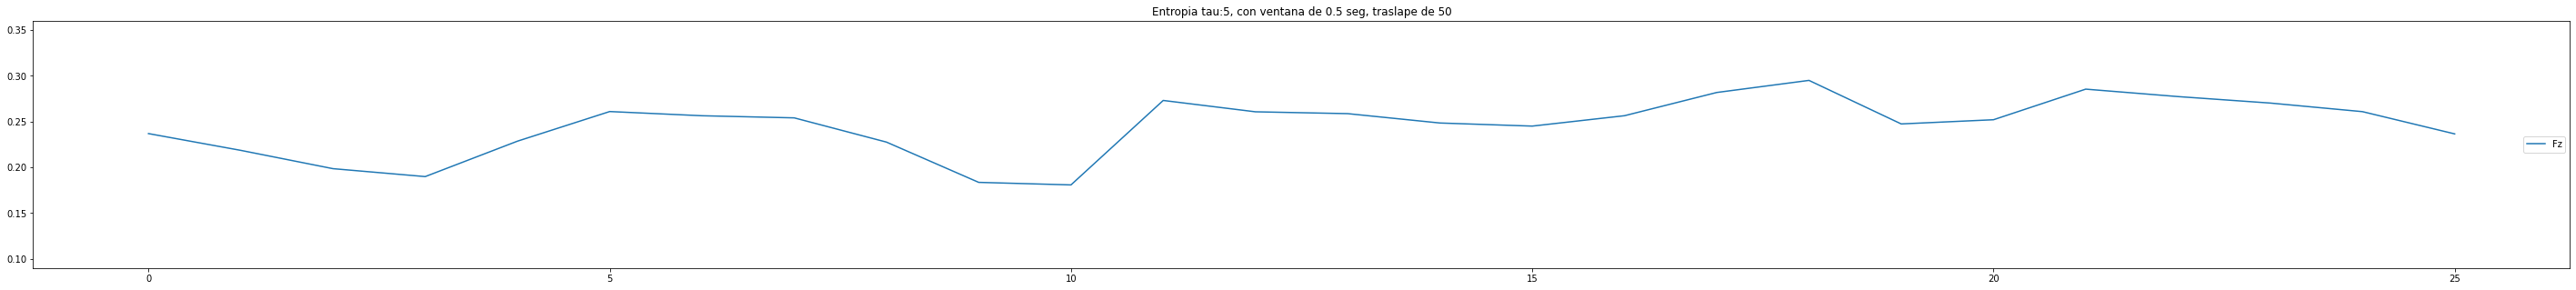

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,5))
# fig,ax = plt.subplots(2,1,sharex=True)
# fig.set_size_inches(50,5)
# plt.figure(figsize=(30,10))
subs = [3]
for s in range(len(entropy_c)):
  plt.subplot(2,1,s+1)
  for i in range(entropy_c[s].shape[1]):
    plt.plot(np.squeeze(entropy_c[s][:,i]), label=channels[i])

  plt.legend(loc='center right',bbox_to_anchor=(1, 0.5))
  plt.title('Sujeto {sub} Entropia tau:{tau_}, con ventana de {ven} seg, traslape de {tra}'.format(sub = subs[s],tau_=20,ven=window/sampling_freq,tra=50))
  plt.ylim(0.09,0.36)
plt.show()

In [ ]:
from scipy.stats import pearsonr,spearmanr
plt.figure(figsize=(20,8))
matr_ = list()
for s in range(len(entropy_c2)):
  matr = np.zeros((entropy_c2[s].shape[1],entropy_c2[s].shape[1]+1))
  entropy_c2[s][np.isnan(entropy_c2[s])]=np.min(entropy_c2[s])

  for ch1 in range(entropy_c2[s].shape[1]):
    for ch2 in range(entropy_c2[s].shape[1]):
      # if ch1 != ch2:
      entropy_c2[s][np.isnan(entropy_c2[s][:,ch1]),ch1] = 0
      entropy_c2[s][np.isnan(entropy_c2[s][:,ch2]),ch2] = 0
          
      matr[ch1,ch2] = np.abs(pearsonr(entropy_c2[s][:,ch1],entropy_c2[s][:,ch2])[0])
      matr[ch2,ch1] = np.abs(pearsonr(entropy_c2[s][:,ch1],entropy_c2[s][:,ch2])[0])
   
  matr[:,19] = np.sum(matr[:,:19],axis=1)/19
  matr_.append(np.sum(matr[:,:19],axis=1)/19)
  # matr[:,19] = (np.mean(matr[:,:19],axis=1)-(np.std(matr[:,:19],axis=1)/2))
  plt.subplot(1,2,s+1)
  plt.imshow(matr,aspect='auto')
  plt.colorbar()
  plt.title('Sujeto {sub}'.format(sub=subs[s]))
plt.show()

In [ ]:
for s in range(len(entropy_c)):
  # plt.subplot(1,2,s+1)
  plt.figure(figsize=(5,5))
  mne.viz.plot_topomap(matr_[s],info,sensors=True,cmap='viridis',vmin=0,vmax=1)